In [1]:
%matplotlib notebook
import  matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from modules.startup import MyFuncs
Abs = MyFuncs.Absorbance

import warnings
warnings.filterwarnings("ignore")

# DataBase

In [2]:
class MyDB():
    
    np = __import__('numpy')
    os = __import__('os')
    base64 = __import__('base64')
    hashlib = __import__('hashlib')
    
    def __init__(self, base_dir = '.'):
        self.base_dir = base_dir
        self.data = {}
        self.paths = {}
        self.update()
        self.spectrometers = MyQuery(self, 'wl', 'spectrometer').result
            
    def update(self):
        for root, directories, filenames in self.os.walk(self.base_dir):
            if '.debris' in root:
                pass
            else:
                for filename in filenames: 
                    if filename[-3:]=='npz' and filename not in self.data.keys():
                        self.data[self.base64.b64encode(self.hashlib.md5(str.encode(filename)).digest()).decode("utf-8") ]= self.np.load(self.os.path.join(root,filename), mmap_mode='r')
                        self.paths[self.np.load(self.os.path.join(root,filename), mmap_mode='r')]= self.os.path.join(root,filename)
                    else:
                        pass
                    
    
class MyQuery():
    def __init__(self, database, *keywords, key='tags'):
        self.database = database
        self.keywords = keywords
        self.key = key
        self.result = self.query(*self.keywords, key=self.key)
        self.t0 = None
        
    def query(self, *keywords, key='tags'):
        query = []
        for id_ in self.database.data.keys():
            if key in self.database.data[id_].keys():
                is_there = []
                for arg in keywords: 
                    if np.ndim(self.database.data[id_][key])==0:
                        if arg in self.database.data[id_][key]:
                            is_there.append(True)
                    else:
                        for tag in self.database.data[id_][key]:
                            if arg in tag:
                                is_there.append(True)
                if len(is_there)==len(keywords):
                    query.append(self.database.data[id_])  
        if len(query)==1:
            query = query[0]

        return query
    
    def print_tags(self):
        if self.result==[]:
            print('No matches found.')
        else:
            for item in self.result:
                print(item['tags'])

    def print_keys(self):
        if self.result==[]:
            print('No matches found.')
        else:
            for item in self.result:
                print(item.keys())

    def select(self, *keywords):
        filtered_query = []
        for result in self.result:
            for arg in keywords:
                is_there=[]
                for key in result.keys():
                    if arg in result[key]:
                        is_there.append(True)
            if len(is_there)==len(keywords):
                    filtered_query.append(result)  
        if len(filtered_query)==1:
            filtered_query = filtered_query[0]
        return filtered_query
    
    
    def sort(self, key, index = None, result = None, getter_func=None):
        if not result:
            result=self.result

        def getKey(item):

            if getter_func:
                return getter_func(item[key])
            elif index:
                return item[key][index]
            else:
                return item[key]
        
        test = []
        for item in result:
            try:            
                item[key]
                test.append(item)
            except KeyError:
                pass
        result = test                
        query = sorted(result, key=getKey)
        self.result = query
        

def value_at_wl(result, wavelengths, wl, box = 2):
    wl_index = np.abs(wavelengths - wl).argmin()
    value = result[wl_index-box:wl_index+box] 
#     if len(value)==1:
#         value = value[0]
    return np.mean(value, axis=0)

def fit_linear( x, y, points, fig = None):

    from scipy.stats import linregress
    points=points
    r_squared = 0.
    best = {}
    best['r_squared'] = r_squared

    for i in range(len(x)-points+1):

        j = points+i               
        fit=linregress(x[i:j], y[i:j])
        r_squared = fit[2]**2

        if r_squared > best['r_squared']:
            best['i'] = i
            best['fit'] = fit
            best['r_squared'] = r_squared
        else:
            pass

#     print('slope', best['fit'][0], '+/-', best['fit'][4])
    if fig==None:
        pass
    else:
        name = 'linear regression:\n R$^2$ = ' +str(round(best['r_squared'],3)) + '\nf(x) = '+str(round(best['fit'][0],3)) + 'x $\pm$ '+str(round(best['fit'][1],3))
        fig.plot(x[best['i']:best['i']+points],[best['fit'][0]*value+best['fit'][1] for value in x[best['i']:best['i']+points]], label=name, c='r')
        fig.legend();

In [3]:
db = MyDB()

# Calibration SENIX#1

In [202]:
def convert_c(item):
    initial_c = 75*10e-6/(75*10e-6+1.5*10e-3)
    dilution = initial_c/float(item.item().split('/')[1])
    return round(100*dilution, 2)

## Pelikan Green

<IPython.core.display.Javascript object>


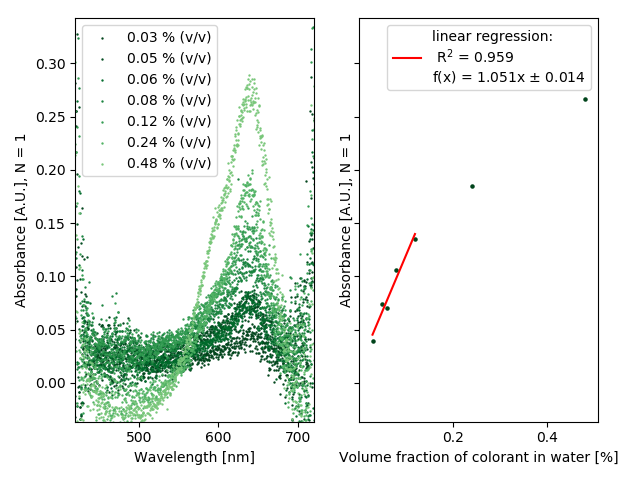

In [252]:
dataset = MyQuery(db, 'SENIX#1', 'Calibration', 'Green', 'biofilm')
water = dataset.restrict('agua')
dataset.sort('concentration', result=list(set(dataset.result)-set([water])) ,getter_func=convert_c)
concentrations = [convert_c(item['concentration']) for item in dataset.result]
calibration_values = []

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
# axes = (ax1, ax2)
color = 0

for i, result in enumerate(dataset.result):
    wavelengths = db.spectrometers[result['detector'].item()] 
    A = Abs(result['intensities'],water['intensities'])
    
    label = str(convert_c(result['concentration'])) +' % (v/v)'
    color +=25
    for spec in A[:-1]:
        ax1.scatter(wavelengths, spec)
        calibration_values.append(value_at_wl(spec, wavelengths, 640))
        
    ax1.scatter(wavelengths, A[-1],c=cm.Greens(300-color), 
             s = 0.5, 
             label=label)
    calibration_values.append(value_at_wl(A[-1], wavelengths, 640))
    
ax2.scatter(concentrations, calibration_values,c=cm.Greens(300), s = 5)

ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax2.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax1.set_xlim((420,720)) 
ax2.set_xlabel('Volume fraction of colorant in water [%]')


ax1.legend();

fit_linear(concentrations, calibration_values, 5, fig=ax2)
# fig.suptitle('SENIX#1 Sensor Calibration:\nAqueous solutions of Pelikan Green')

ax1.relim()
ax1.set_ymargin(.25
               )
ax1.autoscale_view()
fig.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


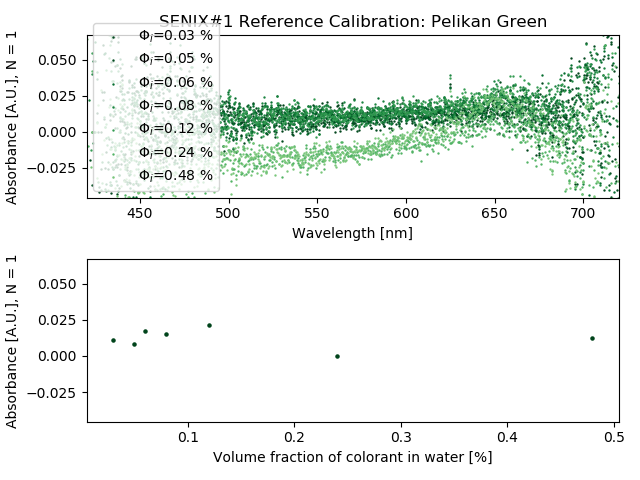

In [208]:
dataset = MyQuery(db, 'SENIX#1', 'Calibration', 'Green', 'ref')
water = dataset.restrict('agua')
dataset.sort('concentration', result=list(set(dataset.result)-set([water])) ,getter_func=convert_c)
concentrations = [convert_c(item['concentration']) for item in dataset.result]
calibration_values = []

fig, (ax1, ax2) = plt.subplots(2,1, sharey=True)
# axes = (ax1, ax2)
color = 0

for i, result in enumerate(dataset.result):
    wavelengths = db.spectrometers[result['detector'].item()] 
    A = Abs(result['intensities'],water['intensities'])
    
    label = '$\Phi_i$='+ str(convert_c(result['concentration'])) +' %'
    color +=25
    for spec in A[:-1]:
        ax1.scatter(wavelengths, spec)
        calibration_values.append(value_at_wl(spec, wavelengths, 640))
        
    ax1.scatter(wavelengths, A[-1],c=cm.Greens(300-color), 
             s = 0.5, 
             label=label)
    calibration_values.append(value_at_wl(A[-1], wavelengths, 640))
    
ax2.scatter(concentrations, calibration_values,c=cm.Greens(300), s = 5)
ax1.set_title('SENIX#1 Reference Calibration: Pelikan Green')
ax1.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax1.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax1.set_xlim((420,720)) 
ax2.set_xlabel('Volume fraction of colorant in water [%]')

ax1.set_ymargin(0.25)
ax1.relim()
ax1.autoscale_view()
ax1.legend();

# fit_linear(concentrations, calibration_values, 7, fig=ax2)

fig.tight_layout()
plt.show()



## Pelikan Red

<IPython.core.display.Javascript object>


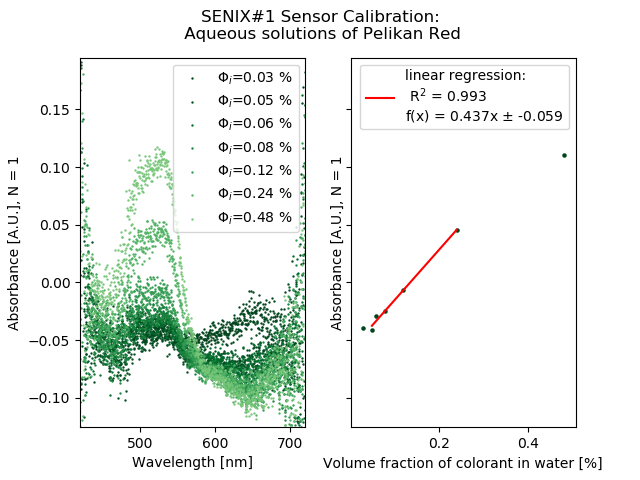

In [227]:
dataset = MyQuery(db, 'SENIX#1', 'Calibration', 'Red', 'biof')
water = MyQuery(db, 'SENIX#1', 'Calibration', 'Green', 'biof').restrict('agua')
dataset.sort('concentration', result=list(set(dataset.result)-set([water])) ,getter_func=convert_c)
concentrations = [convert_c(item['concentration']) for item in dataset.result]
calibration_values = []

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
# axes = (ax1, ax2)
color = 0

for i, result in enumerate(dataset.result):
    wavelengths = db.spectrometers[result['detector'].item()] 
    A = Abs(result['intensities'],water['intensities'])
    
    label = '$\Phi_i$='+ str(convert_c(result['concentration'])) +' %'
    color +=25
    for spec in A[:-1]:
        ax1.scatter(wavelengths, spec)
        calibration_values.append(value_at_wl(spec, wavelengths, 530))
        
    ax1.scatter(wavelengths, A[-1],c=cm.Greens(300-color), 
             s = 0.5, 
             label=label)
    calibration_values.append(value_at_wl(A[-1], wavelengths, 530))
    
ax2.scatter(concentrations, calibration_values,c=cm.Greens(300), s = 5)
fig.suptitle('SENIX#1 Sensor Calibration:\n Aqueous solutions of Pelikan Red')
ax1.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax1.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax1.set_xlim((420,720)) 
ax2.set_xlabel('Volume fraction of colorant in water [%]')


ax1.legend(loc='best');

fit_linear(concentrations, calibration_values, 5, fig=ax2)

ax1.set_ymargin(0.4)
ax1.relim()
ax1.autoscale_view()
# fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


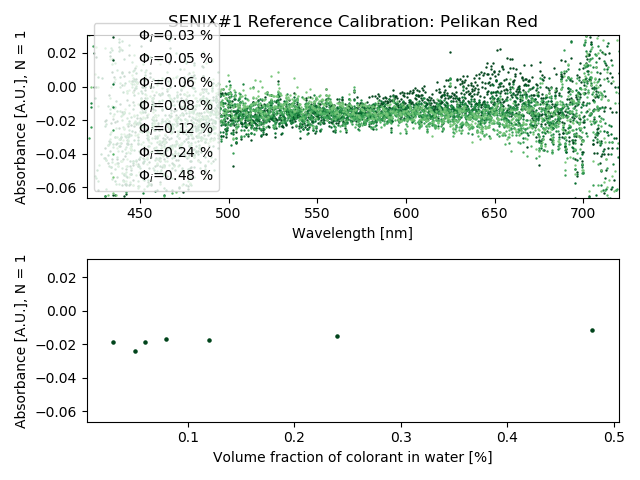

In [212]:
dataset = MyQuery(db, 'SENIX#1', 'Calibration', 'Red', 'ref')
water = MyQuery(db, 'SENIX#1', 'Calibration', 'Green', 'ref').restrict('agua')
dataset.sort('concentration', result=list(set(dataset.result)-set([water])) ,getter_func=convert_c)
concentrations = [convert_c(item['concentration']) for item in dataset.result]
calibration_values = []

fig, (ax1, ax2) = plt.subplots(2,1, sharey=True)
# axes = (ax1, ax2)
color = 0

for i, result in enumerate(dataset.result):
    wavelengths = db.spectrometers[result['detector'].item()] 
    A = Abs(result['intensities'],water['intensities'])
    
    label = '$\Phi_i$='+ str(convert_c(result['concentration'])) +' %'
    color +=25
    for spec in A[:-1]:
        ax1.scatter(wavelengths, spec)
        calibration_values.append(value_at_wl(spec, wavelengths, 530))
        
    ax1.scatter(wavelengths, A[-1],c=cm.Greens(300-color), 
             s = 0.5, 
             label=label)
    calibration_values.append(value_at_wl(A[-1], wavelengths, 530))
    
ax2.scatter(concentrations, calibration_values,c=cm.Greens(300), s = 5)
ax1.set_title('SENIX#1 Reference Calibration: Pelikan Red')
ax1.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax1.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()))
ax1.set_xlim((420,720)) 
ax2.set_xlabel('Volume fraction of colorant in water [%]')

ax1.set_ymargin(0.25)
ax1.relim()
ax1.autoscale_view()
ax1.legend();

# fit_linear(concentrations, calibration_values, 6, fig=ax2)

fig.tight_layout()
plt.show()

# SENIX#1: Pilot Plant - Initial intensities

In [5]:
reference = MyQuery(db, 'CETAQUA', 'pilot', 'Ref')
sensor = MyQuery(db, 'CETAQUA', 'pilot', 'Biofilm')

In [6]:
sensor.sort('time', index=1)
reference.sort('time', index=1)

reference.result, sensor.result = reference.result[12:], sensor.result[12:]
readouts =[reference, sensor]

In [10]:
import ipywidgets as widgets
from ipywidgets import interactive


times={}
for result in sensor.result:
    times[str(round(result['time'][1]/60/60, 5))+' hours'] = result['time'][1]

def select_t0(time):
    #print('Selected:', [dataset.select(times[time]) for dataset in readouts])
    #return sensor.select(time)
    for dataset in readouts:
        dataset.t0 = times[time]
    

ref_selector = widgets.Select(
    options=[time for time in times.keys()],
    value=[time for time in times.keys()][0],
    rows=3,
    description='Select t$_0$:',
    disabled=False
)

interactive(select_t0, time=ref_selector)

A Jupyter Widget

<IPython.core.display.Javascript object>


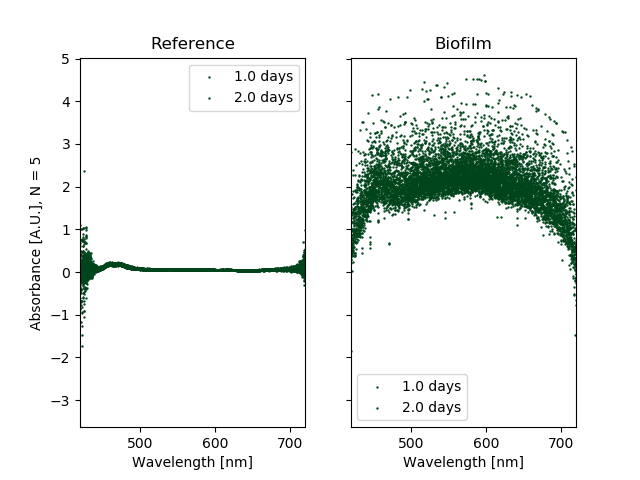

A Jupyter Widget

In [8]:

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True)
axes = (ax1, ax2)
    
def plots(index_range):
    
    for i, dataset in enumerate(readouts):
        axes[i].clear()
        color = 0
                
        for result in dataset.result[index_range[0]:index_range[1]]:    
            label = str(round(result['time'][1]/60/60/24, ))+' days'
            wavelengths = db.spectrometers[result['detector'].item()] 
            A = Abs(result['intensities'],dataset.select(dataset.t0)['intensities'])
            
            for spec in A[:-1]:
                axes[i].scatter(wavelengths, spec, c=cm.Greens(300), 
                 s = 0.5 )
            axes[i].scatter(wavelengths, A[-1],c=cm.Greens(300-color), 
                 s = 0.5, 
                label=label
                           )
            color+=20
        axes[i].set_title(result['tags'][1])
        axes[i].set_xlabel('Wavelength [nm]')
        axes[i].legend();
    axes[0].set_xlim((420, 720))    
    axes[0].set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()));
    axes[0].relim()
    axes[0].autoscale_view()
    plt.show()

options = [i for i in range(len(sensor.result))]
range_selector = widgets.SelectionRangeSlider(
        options=options,
        value = (2,4),
        #index=(0,len(options)-1),
        description='define range',
        continuous_update =False,
        disabled=False
        )

interactive_plot = interactive(plots, index_range = range_selector)
interactive_plot

<IPython.core.display.Javascript object>


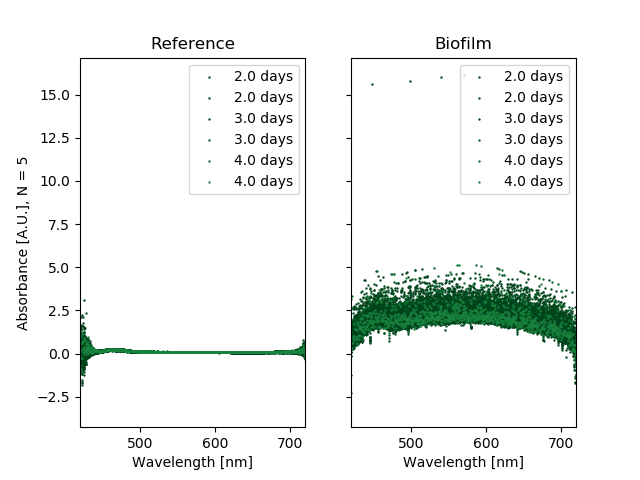

A Jupyter Widget

In [9]:
import ipywidgets as widgets
from ipywidgets import interactive

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True)
axes = (ax1, ax2)
    
def plots(index_range):
    
    for i, dataset in enumerate(readouts):
        axes[i].clear()
        color = 0
        
        for result in dataset.result[index_range[0]:index_range[1]]:    
            label = str(round(result['time'][1]/60/60/24, 1))+' days'
            wavelengths = db.spectrometers[result['detector'].item()] 
            I = result['intensities']
            for spec in I[:-1]:
                axes[i].scatter(wavelengths, spec, c=cm.Greens(300), 
                 s = 0.5 )
            axes[i].scatter(wavelengths, I[-1],c=cm.Greens(300-color), 
                 s = 0.5, 
                label=label
                           )
            color+=20
        axes[i].set_title(result['tags'][1])
        axes[i].set_xlabel('Wavelength [nm]')
        axes[i].legend();
    axes[0].set_ylabel('Intensities [counts], N = '+str(result['N'].item()));
    axes[1].relim()
    axes[1].autoscale_view()
    plt.show()

options = [i for i in range(len(sensor.result))]
range_selector = widgets.SelectionRangeSlider(
        options=options,
        value = (12,14),
        #index=(0,len(options)-1),
        description='define range',
        continuous_update =False,
        disabled=False
        )

interactive_plot = interactive(plots, index_range = range_selector)
interactive_plot

In [142]:
import numpy as np
import time
import os

from filelock import UnixFileLock
lock = UnixFileLock('saving.lock')

while True:
    
    with lock.acquire():
        
        np.save('test', np.array([1,2,3,4]))
        time.sleep(3)
        
    time.sleep(5)

KeyboardInterrupt: 